# Product Idea for Accounts
Accounts are split in two groups: "Free only" and "PMOF"

I want to design a data product that can help "Free only" accounts to convert to "PMOF"

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
df_account = pd.read_csv('../challenge_data/account_dat.csv')
df_app = pd.read_csv('../challenge_data/app_dat.csv')
df_category = pd.read_csv('../challenge_data/category_ref.csv')
df_device = pd.read_csv('../challenge_data/device_ref.csv')
df_in_app = pd.read_csv('../challenge_data/in-app_dat.csv')
df_transaction = pd.read_csv('../challenge_data/transaction_dat.csv')

In [3]:
df_in_app_denorm = df_in_app.join(df_app.set_index('content_id'), on='parent_app_content_id')\
                .join(df_category.set_index('category_id'), on='category_id')\
                .join(df_device.set_index('device_id'), on='device_id')
df_in_app_denorm.head()

,parent_app_content_id,content_id,type,app_name,category_id,device_id,category_name,device_name
0,d2bde35599e0dae9,227227a77c59809b,consumable,lactantem prevailing,Z-1,3,Games,Both
1,d2bde35599e0dae9,41ac2362a2600185,consumable,lactantem prevailing,Z-1,3,Games,Both
2,d2bde35599e0dae9,64a8e16f030bb611,consumable,lactantem prevailing,Z-1,3,Games,Both
3,d2bde35599e0dae9,2c8ba424183afa7c,consumable,lactantem prevailing,Z-1,3,Games,Both
4,d2bde35599e0dae9,b4c42fa5cc420f7b,consumable,lactantem prevailing,Z-1,3,Games,Both


In [4]:
df_app_denorm = df_app.join(df_category.set_index('category_id'), on='category_id')\
                .join(df_device.set_index('device_id'), on='device_id')
df_app_denorm['type'] = 'download_only'
df_app_denorm.head()

,app_name,content_id,category_id,device_id,category_name,device_name,type
0,half-slouched having,22dfac9721b899cb,Y-8,3,Photos & Videos,Both,download_only
1,lift whale-ships,7c645810cd7f166e,M-7,3,Utilities,Both,download_only
2,mightily community,c495bcb878faffaa,Y-8,2,Photos & Videos,iPad,download_only
3,session: too--shall,4e683dcd461cdd22,Y-8,1,Photos & Videos,iPhone,download_only
4,That Zoology,6473dd29a2badbf1,Y-8,3,Photos & Videos,Both,download_only


In [5]:
cols_app = ['app_name', 'content_id', 'type', 'category_name', 'device_name']
df_app_all = pd.concat([df_in_app_denorm[cols_app],
                        df_app_denorm[cols_app]])
df_app_all

,app_name,content_id,type,category_name,device_name
0,lactantem prevailing,227227a77c59809b,consumable,Games,Both
1,lactantem prevailing,41ac2362a2600185,consumable,Games,Both
2,lactantem prevailing,64a8e16f030bb611,consumable,Games,Both
3,lactantem prevailing,2c8ba424183afa7c,consumable,Games,Both
4,lactantem prevailing,b4c42fa5cc420f7b,consumable,Games,Both
...,...,...,...,...,...
995,animals nights--do,71cc78b6addcdc63,download_only,Entertainment,Both
996,meeting-house? respond,42e45e59e6d3dcf1,download_only,Photos & Videos,Both
997,--SIBBALD'S occupation,d862535438d4314c,download_only,Utilities,Both
998,cylinders vain!,07d53efa8e531e15,download_only,Photos & Videos,Both


In [6]:
df_trn_denorm = df_transaction.join(df_device.set_index('device_id'), on='device_id')\
                    .join(df_account.set_index('acct_id'), on='acct_id', lsuffix='_transaction', rsuffix='_acct')

# fill accounts that cannot join to payment_type
df_trn_denorm['payment_type'] = df_trn_denorm['payment_type'].fillna('unknown')

In [7]:
df_wide = df_trn_denorm.join(df_app_all.drop(columns=['device_name'])\
                             .set_index('content_id'), on='content_id')

In [12]:
df_wide['acct_id'].nunique()

30000

In [9]:
df_wide[['acct_id', 'payment_type']].groupby(by=['payment_type']).nunique()

,acct_id
payment_type,
Free only,14993
PMOF,14982
unknown,25


In [8]:
df_wide[['acct_id', 'payment_type', 'category_name']].groupby(by=['payment_type','category_name']).nunique()

acct_id
payment_type category_name             
Free only    Entertainment        14993
             Games                14993
             Photos & Videos      14993
             Social Networking    14515
             Utilities            14993
PMOF         Entertainment        14982
             Games                14982
             Photos & Videos      14982
             Social Networking    14964
             Utilities            14982
unknown      Entertainment           25
             Games                   25
             Photos & Videos         25
             Social Networking       25
             Utilities               25

The dataset is split evenly between "Free only" and "PMOF". There are 25 accounts that have "unknown" payment type. We are going to omit these accounts going forward.

### Check account interaction with content type 

In [11]:
df_1 = df_wide[df_wide['payment_type'] != 'unknown']
df_1[['acct_id', 'payment_type', 'category_name', 'type']]\
.groupby(by=['payment_type', 'type','category_name']).nunique()

acct_id
payment_type type          category_name             
Free only    download_only Entertainment        14993
                           Games                14993
                           Photos & Videos      14993
                           Social Networking    14515
                           Utilities            14993
PMOF         consumable    Entertainment        14977
                           Games                14982
                           Photos & Videos      14982
                           Social Networking    14917
                           Utilities            14980
             download_only Entertainment        14004
                           Games                14982
                           Photos & Videos      14850
                           Social Networking     8854
                           Utilities            14401
             subscription  Entertainment        14319
                           Photos & Videos      14900
                           Social Networking     6127
                           Utilities            13911

In [18]:
df_1 = df_wide[df_wide['payment_type'] != 'unknown']
df_1[['acct_id', 'price', 'payment_type', 'category_name', 'type']]\
.groupby(by=['payment_type', 'type','category_name'], as_index=False)\
.agg(acct_cnt=('acct_id', 'nunique'),
    revenue=('price', 'sum'),
    trn_cnt=('acct_id', 'count'))

,payment_type,type,category_name,acct_cnt,revenue,trn_cnt
0,Free only,download_only,Entertainment,14993,0.00,203488
1,Free only,download_only,Games,14993,0.00,406380
2,Free only,download_only,Photos & Videos,14993,0.00,275838
3,Free only,download_only,Social Networking,14515,0.00,51698
4,Free only,download_only,Utilities,14993,0.00,229867
5,PMOF,consumable,Entertainment,14977,875213.56,130544
6,PMOF,consumable,Games,14982,11854078.71,1039829
7,PMOF,consumable,Photos & Videos,14982,2696202.67,414333
8,PMOF,consumable,Social Networking,14917,548519.20,86580
9,PMOF,consumable,Utilities,14980,823959.55,149345


### Group accounts together?
I wonder if there are meaningful account segments to group together. I want to cluster 'Free only' and 'PMOF' accounts together into segments. 

#### Question
Do 'PMOF' accounts have transactions on content that 'Free only' accounts have transactions on?
> Answer: No as shown below

In [20]:
free_content = df_1[df_1['payment_type'] == 'Free only']['content_id'].unique()
pmof_content = df_1[df_1['payment_type'] == 'PMOF']['content_id'].unique()

In [23]:
np.isin(pmof_content, free_content).sum()

0

Because 'Free only' and 'PMOF' accounts do not have overlapping content, we cannot use the user-content interaction matrix to recommend contents for accounts with different payment_types. A recommendation system will only recommend content to accounts within each payment_type

#### Use the application 'category_name' feature
Each content has a category feature. We can use 'category_name' as a feature to see how accounts interact with each category. Because 'Free only' accounts only transact at the app level ('download_only') and do not have price>0, we will compare account interactions on number of app downloads.

In [30]:
df_download = df_1[df_1['type'] == 'download_only']

df_acct_cat = df_download[['acct_id', 'category_name', 'content_id']]\
                .groupby(['acct_id', 'category_name'], as_index=False).agg(trn_cnt=('content_id','count'))

df_cat_trn = df_acct_cat.pivot(index='acct_id', columns=['category_name'], values='trn_cnt').fillna(0)

In [33]:
df_cat_trn.head()

category_name,Entertainment,Games,Photos & Videos,Social Networking,Utilities
acct_id,,,,,
00028709c8d435ff,10.0,27.0,19.0,1.0,14.0
0005a4d77127fde7,6.0,16.0,3.0,0.0,1.0
0005c296f2605c08,4.0,17.0,4.0,1.0,1.0
00082ad3dc50a70d,15.0,30.0,17.0,3.0,11.0
00085ff73786df4d,3.0,14.0,2.0,2.0,2.0


In [36]:
# should I scale transaction count (trn_cnt)?
df_cat_trn.describe()

category_name,Entertainment,Games,Photos & Videos,Social Networking,Utilities
count,29975.000000,29975.000000,29975.000000,29975.000000,29975.000000
mean,8.148691,21.972177,11.587389,2.175513,9.258048
std,6.139317,6.710031,7.623328,1.958020,6.795016
min,0.000000,6.000000,0.000000,0.000000,0.000000
25%,3.000000,17.000000,5.000000,1.000000,3.000000
50%,7.000000,21.000000,10.000000,2.000000,8.000000
75%,13.000000,27.000000,18.000000,3.000000,15.000000
max,30.000000,48.000000,35.000000,12.000000,34.000000


In [37]:
from sklearn.cluster import KMeans

In [38]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_cat_trn)
    distortions.append(kmeanModel.inertia_)

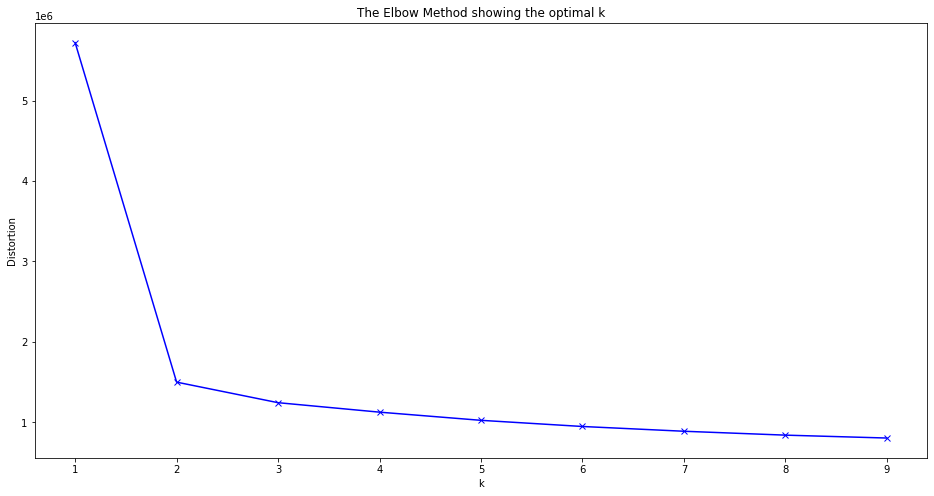

In [39]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Scaling features shows same result

In [40]:
from sklearn.preprocessing import StandardScaler

In [41]:
scaler = StandardScaler()
scaled_df_cat_trn = scaler.fit_transform(df_cat_trn)

In [45]:
scaler.mean_

array([ 8.14869058, 21.97217681, 11.58738949,  2.17551293,  9.25804837])

In [44]:
scaled_df_cat_trn[0:5]

array([[ 0.30155479,  0.74931206,  0.9723751 , -0.6003679 ,  0.69786891],
       [-0.3499944 , -0.890052  , -1.12648084, -1.11109635, -1.21532981],
       [-0.67576899, -0.74101891, -0.99530234, -0.6003679 , -1.21532981],
       [ 1.11599126,  1.19641135,  0.71001811,  0.42108901,  0.25636151],
       [-0.83865628, -1.1881182 , -1.25765933, -0.08963945, -1.06816068]])

In [42]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(scaled_df_cat_trn)
    distortions.append(kmeanModel.inertia_)

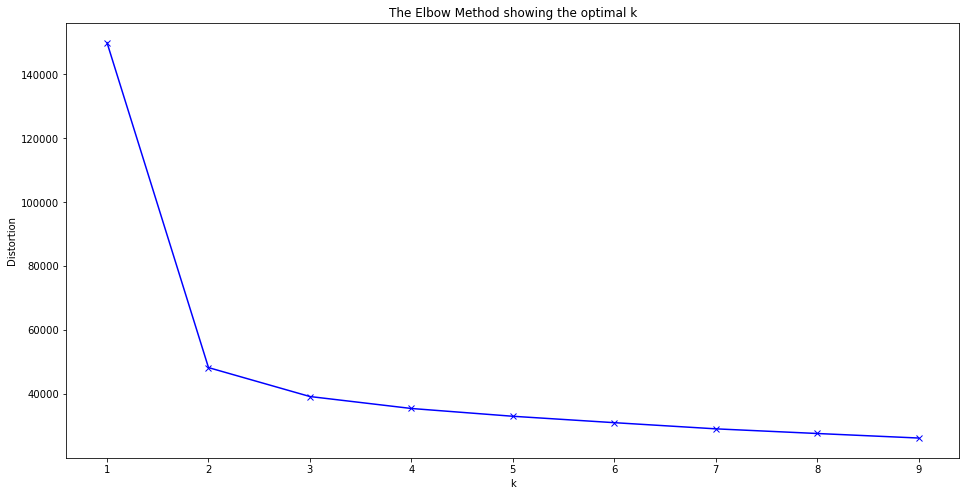

In [43]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Let's join payment_type
Optimal k is 2. This is likely due to two different payment_types. Let's assign clusters and see if it matches up to payment_type

In [48]:
kmeanModel2 = KMeans(n_clusters=2)
kmeanModel2.fit(scaled_df_cat_trn)
df_cat_trn['pred_k'] = kmeanModel2.predict(scaled_df_cat_trn)

In [47]:
df_cat_trn.head()

category_name,Entertainment,Games,Photos & Videos,Social Networking,Utilities,k_cluster
acct_id,,,,,,
00028709c8d435ff,10.0,27.0,19.0,1.0,14.0,1
0005a4d77127fde7,6.0,16.0,3.0,0.0,1.0,0
0005c296f2605c08,4.0,17.0,4.0,1.0,1.0,0
00082ad3dc50a70d,15.0,30.0,17.0,3.0,11.0,1
00085ff73786df4d,3.0,14.0,2.0,2.0,2.0,0


In [49]:
df_cat_trn.join(df_account.set_index('acct_id'), on='acct_id')

,Entertainment,Games,Photos & Videos,Social Networking,Utilities,k_cluster,pred_k,create_dt,payment_type
acct_id,,,,,,,,,
00028709c8d435ff,10.0,27.0,19.0,1.0,14.0,1,1,11/25/13,Free only
0005a4d77127fde7,6.0,16.0,3.0,0.0,1.0,0,0,12/20/07,PMOF
0005c296f2605c08,4.0,17.0,4.0,1.0,1.0,0,0,4/2/11,PMOF
00082ad3dc50a70d,15.0,30.0,17.0,3.0,11.0,1,1,5/16/15,Free only
00085ff73786df4d,3.0,14.0,2.0,2.0,2.0,0,0,3/4/12,PMOF
...,...,...,...,...,...,...,...,...,...
fffa8862c0263635,2.0,21.0,4.0,1.0,2.0,0,0,7/31/12,PMOF
fffb6b3ecb46225b,14.0,24.0,14.0,5.0,13.0,1,1,1/9/16,Free only
fffceef017abbe30,16.0,24.0,11.0,4.0,15.0,1,1,2/23/14,Free only
